# Market Microstructure Analysis
**Objective:** Validate input data integrity, session density, and volatility regimes.

**Target Asset:** NQ (Nasdaq-100 E-mini Futures)
**Data Source:** 1-Minute OHLCV (RTH Parsed)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("bmh")

# 1. Load Data
DATA_PATH = Path(
    "../../data/vendor_parquet/NQ/NQ.v.0_2024-12-01_2025-11-30_RTH.parquet"
)

if not DATA_PATH.exists():
    print("Production data not found. Falling back to synthetic sample.")
    DATA_PATH = Path("../../data/sample/synth_3d_RTH.parquet")

if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)

    # Ensure DatetimeIndex for time-series analysis
    if not isinstance(df.index, pd.DatetimeIndex):
        if "date" in df.columns:
            time_col = "date"
        elif "time" in df.columns:
            time_col = "time"
        else:
            time_col = df.columns[0]

        df[time_col] = pd.to_datetime(df[time_col])
        df.set_index(time_col, inplace=True)

    print(f"Loaded {len(df)} rows from {DATA_PATH.name}")
else:
    raise FileNotFoundError("No data found.")

Loaded 99840 rows from NQ.v.0_2024-12-01_2025-11-30_RTH.parquet


count    256.0
mean     390.0
std        0.0
min      390.0
25%      390.0
50%      390.0
75%      390.0
max      390.0
dtype: float64


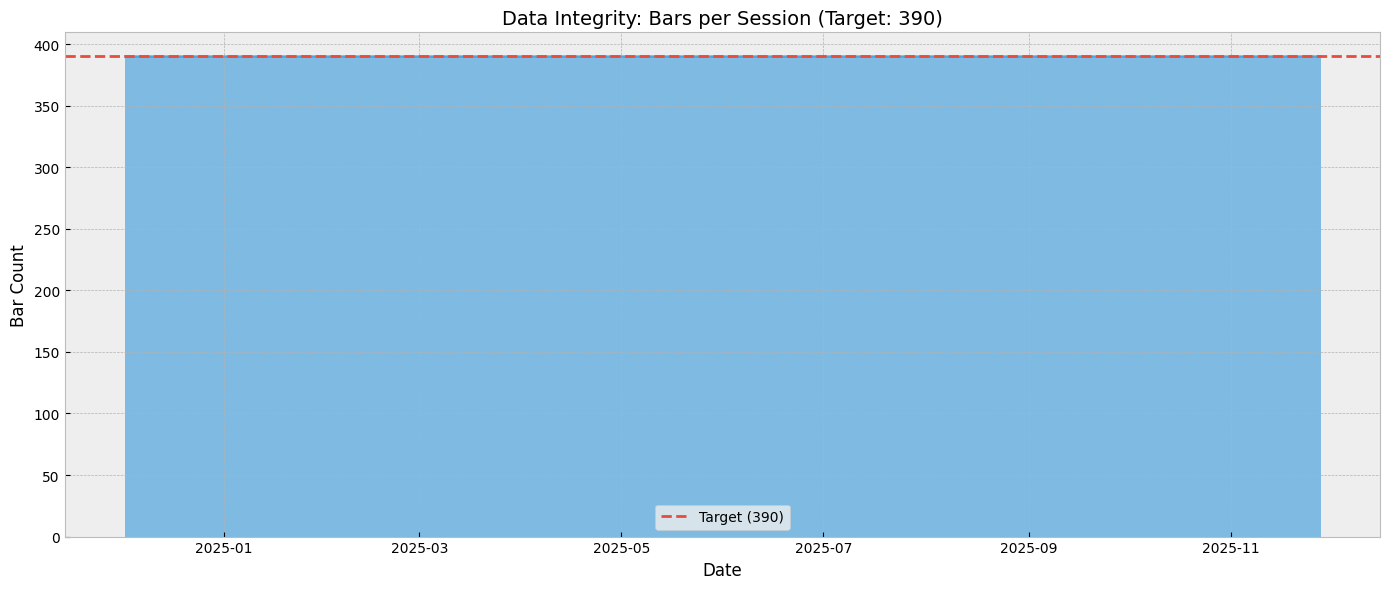

In [2]:
# 2. Session Density Validation
if not df.empty:
    counts = df.groupby(df.index.date).size()
    print(counts.describe())

    fig, ax = plt.subplots(figsize=(14, 6))
    counts.plot(kind="area", color="#3498db", alpha=0.6, ax=ax)

    ax.set_title("Data Integrity: Bars per Session (Target: 390)", fontsize=14)
    ax.axhline(390, color="#e74c3c", linestyle="--", linewidth=2, label="Target (390)")
    ax.set_ylabel("Bar Count")
    ax.set_xlabel("Date")
    ax.legend()

    plt.tight_layout()
    plt.show()

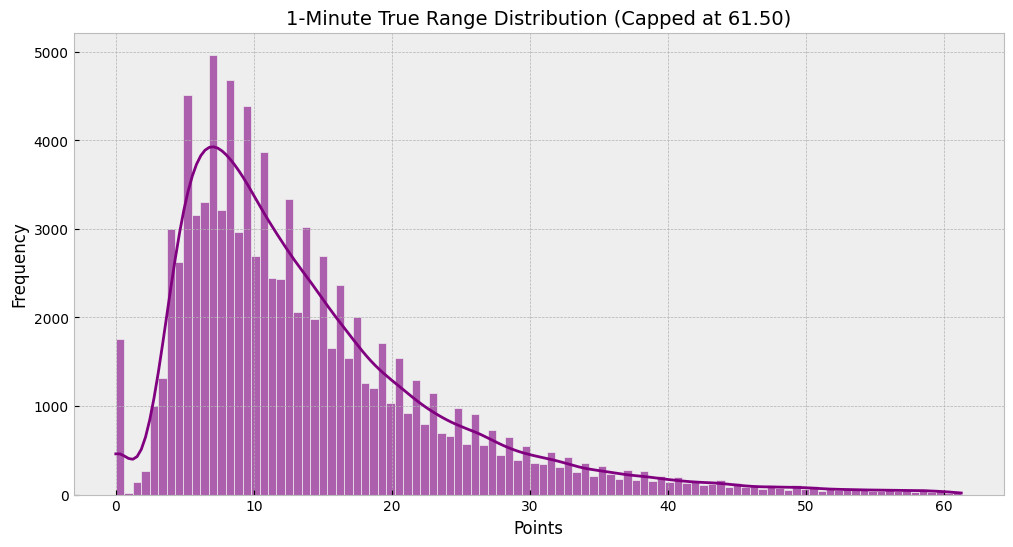

Mean TR: 15.04
Median TR: 11.50


In [3]:
# 3. Volatility Regime Analysis (1-Minute True Range)
if not df.empty:
    high = df["high"]
    low = df["low"]
    close = df["close"]
    prev_close = close.shift(1)

    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Filter outliers (99th percentile) for visualization
    cap = true_range.quantile(0.99)
    filtered_tr = true_range[true_range < cap]

    plt.figure(figsize=(12, 6))
    sns.histplot(filtered_tr, kde=True, bins=100, color="purple", alpha=0.6)
    plt.title(f"1-Minute True Range Distribution (Capped at {cap:.2f})", fontsize=14)
    plt.xlabel("Points")
    plt.ylabel("Frequency")
    plt.show()

    print(f"Mean TR: {true_range.mean():.2f}")
    print(f"Median TR: {true_range.median():.2f}")